In [147]:
import pandas as pd
from pymongo import MongoClient

In [148]:
DATASET = "128K_10"

In [149]:
# Set connection
# client = MongoClient("mongodb://localhost:27017/")
# db = client["bank"]
# balances_collection = db["balances"]

# Load csv
accounts = pd.read_csv(f"sample/gamlnet_data/{DATASET}/accounts.csv")
transactions = pd.read_csv(f"sample/gamlnet_data/{DATASET}/transactions.csv", parse_dates=["tran_timestamp"])

In [150]:
print(transactions["tran_timestamp"].max())  # Should be 2018-12-21

2018-12-21 00:00:00+00:00


In [151]:
transactions["tx_type"].unique()

array(['TRANSFER'], dtype=object)

In [152]:
# Create root
balances = {}

OPEN_DATE_REFERENCE = "2017-01-01"  # Define the reference date
transactions['tran_timestamp'] = pd.to_datetime(transactions['tran_timestamp'])

# Take users data from account.csv
for _, row in accounts.iterrows():
    acc_id = row["acct_id"] # User id
    open_date = OPEN_DATE_REFERENCE if row["open_dt"] == 0 else row["open_dt"]
    initial_balance = round(float(row["initial_deposit"]), 2)

    balances[acc_id] = [{"date": open_date,
                         "balance": initial_balance
                        }]
    
    if acc_id == 0: # Check
        print("first user must be 0 => ",str(acc_id))
        print("user 0 initial deposit must be 96646.86 => ", initial_balance)

first user must be 0 =>  0
user 0 initial deposit must be 96646.86 =>  78581.41


In [153]:
print(len(transactions))

3768588


In [154]:
balances[0][0]

{'date': '2017-01-01', 'balance': 78581.41}

In [155]:
# Apply transactions to users' balances
transactions.sort_values(by="tran_timestamp")

# Track the last balance for each account
current_balances = {acct_id: balances[acct_id][0]["balance"] for acct_id in balances}

for i, (_, row) in enumerate(transactions.iterrows()):
    # orig_acct = str(row["orig_acct"])
    # bene_acct = str(row["bene_acct"])
    orig_acct = row["orig_acct"]
    bene_acct = row["bene_acct"]
    amount = row["base_amt"]
    tx_type = row['tx_type']
    date = row["tran_timestamp"].strftime("%Y-%m-%d")

    if i == 0:
        print("first transaction must be from 982 to 23 => ", orig_acct, bene_acct)
    if i == 121456: # check that read till the last transaction
        print("\nlast transaction must be from 979 to 10 => ", orig_acct, bene_acct)

    if orig_acct in balances: # check that sender has a deposit
        last_balance = balances[orig_acct][-1]["balance"] # read balance from balances
        if tx_type in ['TRANSFER', 'WITHDRAWAL']: # all TRANSFER in the csv
            new_balance = last_balance - amount
        # elif tx_type == 'DEPOSIT':
        #    new_balance = last_balance + amount

        balances[orig_acct].append({"date": date, "balance": round(new_balance, 2)})
        if orig_acct == 0:
            print()
            print(row['tran_id'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {orig_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[orig_acct])
            
    
    if bene_acct in balances: # check that receiver has a deposit
        last_balance = balances[bene_acct][-1]["balance"]
        if tx_type in ['TRANSFER', 'DEPOSIT']:
            new_balance = last_balance + amount
        # elif tx_type == 'WITHDRAWAL':
        #     new_balance = last_balance - amount

        balances[bene_acct].append({"date": date, "balance": round(new_balance, 2)})
        if bene_acct == 0:
            print()
            print(row['tran_id'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {bene_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[bene_acct])
            

first transaction must be from 982 to 23 =>  5829 235

last transaction must be from 979 to 10 =>  4107 1942

362450
on date 2017-03-02 user 1200 send to 0 152.17 dollars
user 0 balance goes from 78581.41 to 78733.58
[{'date': '2017-01-01', 'balance': 78581.41}, {'date': '2017-03-02', 'balance': 78733.58}]

368878
on date 2017-03-03 user 1200 send to 0 548.72 dollars
user 0 balance goes from 78733.58 to 79282.3
[{'date': '2017-01-01', 'balance': 78581.41}, {'date': '2017-03-02', 'balance': 78733.58}, {'date': '2017-03-03', 'balance': 79282.3}]


In [156]:
balances[1]

[{'date': '2017-01-01', 'balance': 77130.3}]

In [157]:
len(balances)

128002

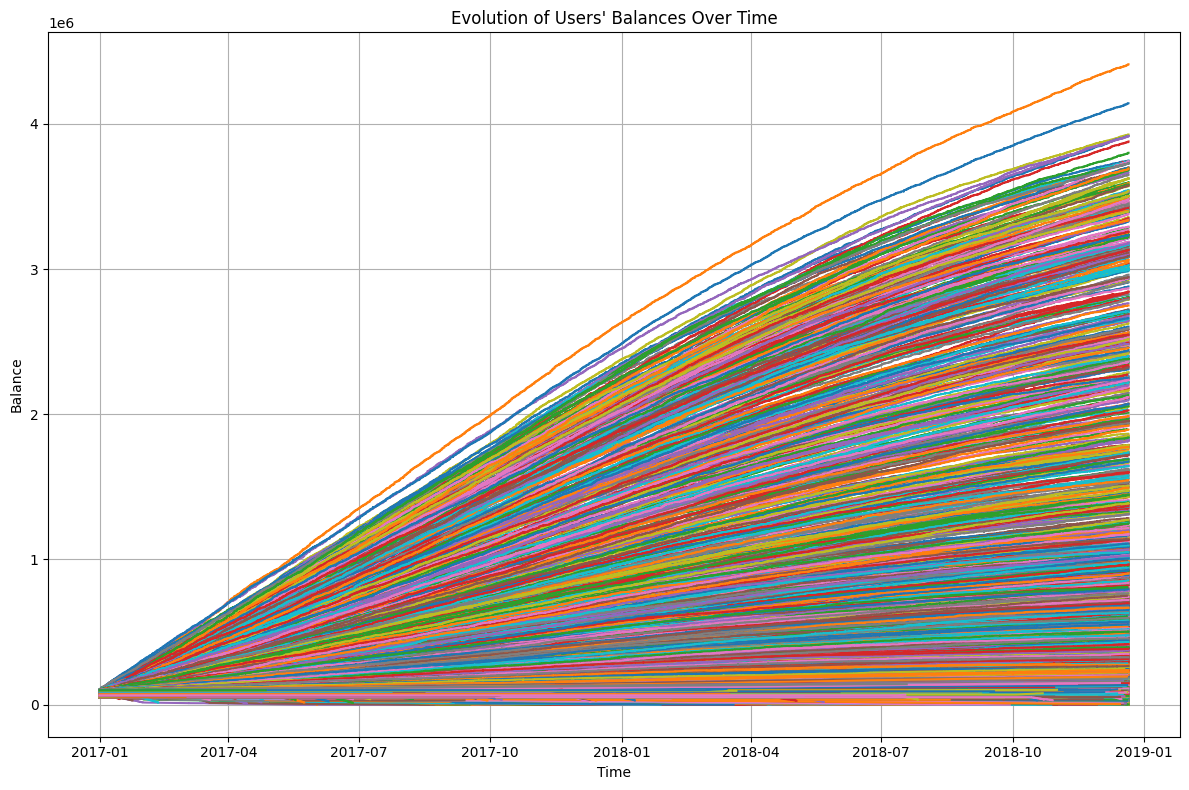

In [158]:
import matplotlib.pyplot as plt
from datetime import datetime

# Plot the balance evolution for each account
plt.figure(figsize=(12, 8))
for acct_id, account_data in balances.items():
    dates = [datetime.strptime(entry["date"], "%Y-%m-%d") for entry in account_data]
    balance_values = [entry["balance"] for entry in account_data]
    plt.plot(dates, balance_values, label=f'Account {acct_id}')

plt.title('Evolution of Users\' Balances Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
import numpy as np

def is_monotonic(balance_values):
    return np.all(np.diff(balance_values) >= 0) or np.all(np.diff(balance_values) <= 0)

monotonic_accounts = []
non_monotonic_accounts = []

for acct_id, account_data in balances.items():
    account_data = sorted(account_data, key=lambda x: x["date"])  # Ordina per data
    balance_values = [entry["balance"] for entry in account_data]
    
    if is_monotonic(balance_values):
        monotonic_accounts.append(acct_id)
    else:
        non_monotonic_accounts.append(acct_id)

print(f"Monotonic Account: {len(monotonic_accounts)}")
print(f"Non Monotonic Account: {len(non_monotonic_accounts)}")
print(f"Percentage of monotonic account: {round(((len(monotonic_accounts) / len(balances)) * 100),2)}%")

assert len(balances) == (len(monotonic_accounts) + len(non_monotonic_accounts))

Monotonic Account: 110796
Non Monotonic Account: 17206
Percentage of monotonic account: 86.56%


In [160]:
# import numpy as np
# from datetime import datetime

# account_ids = list(balances.keys()) # Convert balances dictionary to a list of account IDs
# batch_size = 50  # Adjust based on visibility needs
# num_batches = int(np.ceil(len(account_ids) / batch_size))

# for i in range(num_batches):
#     plt.figure(figsize=(12, 8))
    
#     # Select a batch of accounts
#     batch_accounts = account_ids[i * batch_size:(i + 1) * batch_size]
    
#     for acct_id in batch_accounts:
#         account_data = balances[acct_id]
#         if acc_id == 0:
#             print(account_data)
#         # dates = [entry["date"] for entry in account_data]
#         dates = [datetime.strptime(entry["date"], "%Y-%m-%d") for entry in account_data]
#         balance_values = [entry["balance"] for entry in account_data]
#         plt.plot(dates, balance_values, label=f'Account {acct_id}')
    
#     plt.title(f'Users\' Balances Over Time (Batch {i+1}/{num_batches} users from {batch_accounts[0]} to {batch_accounts[-1]})')
#     plt.xlabel('Time')
#     plt.ylabel('Balance')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [161]:
# # Send the data to DB
# for date in sorted(set(transactions["tran_timestamp"].dt.strftime("%Y-%m-%d"))):
#     daily_balances = {
#         "date": date,
#         "balances": {
#             str(user): {
#                 "balance": next((entry["balance"] for entry in reversed(b) if entry["date"] <= date), b[0]["balance"])
#             } for user, b in balances.items()}
#     }
#     balances_collection.insert_one(daily_balances)

# print("All balances are now updated in the DB with transactions from 2017-01-01 to 2018-12-21")